In [1]:
import pandas as pd

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import tensorflow as tf 

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization

In [2]:
df=pd.read_csv("Expedia.csv")

In [3]:
print("************************ Exploratory Data Analysis ************************\n\n")
print("------------------ Displaying head ------------------\n")
display(df.head())
print("\n------------------ Dimensions of dataset ------------------\n")
display(df.shape)
print("\n------------------ Contents of dataset  ------------------\n")
display(df.info())

************************ Exploratory Data Analysis ************************


------------------ Displaying head ------------------



,id,region,latitude,longitude,accommodation_type,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels,yearly_availability
0,13232,Manhattan,40.71854,-74.00439,Entire home/apt,170,5,7,0.56,929983,1,0
1,246,Brooklyn,40.64446,-73.95030,Entire home/apt,65,3,238,2.30,281764,1,0
2,19091,Queens,40.78573,-73.81062,Private room,85,1,0,NaN,19923341,1,1
3,34305,Manhattan,40.73863,-73.98002,Private room,210,30,0,NaN,200380610,65,1
4,444,Manhattan,40.82426,-73.94630,Shared room,75,3,38,0.42,745069,3,1



------------------ Dimensions of dataset ------------------



(2870, 12)


------------------ Contents of dataset  ------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2870 entries, 0 to 2869
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   2870 non-null   int64  
 1   region               2870 non-null   object 
 2   latitude             2870 non-null   float64
 3   longitude            2870 non-null   float64
 4   accommodation_type   2870 non-null   object 
 5   cost                 2870 non-null   int64  
 6   minimum_nights       2870 non-null   int64  
 7   number_of_reviews    2870 non-null   int64  
 8   reviews_per_month    2194 non-null   float64
 9   owner_id             2870 non-null   int64  
 10  owned_hotels         2870 non-null   int64  
 11  yearly_availability  2870 non-null   int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 269.2+ KB


None

In [4]:
print("\n------------------ Summary of Numerical feature  ------------------\n")
def custom_summary(df):
    from collections import OrderedDict

    result=[]
    for col in df.columns:
        if df[col].dtype != 'object':
            stats=OrderedDict({'Feature_name':col,
                               'datatype' :df[col].dtype,
                               'Count'    :df[col].count(),
                               'min'      :df[col].min(),
                               'quartile1':df[col].quantile(0.25),
                               'Mean'     :df[col].mean(),
                               'Median'   :df[col].median(),
                               'quartile3':df[col].quantile(0.75),
                               'max'      :df[col].max(),
                               'Std dev'  :round(df[col].std(),2),
                               'Skewness' :round(df[col].skew(),2),
                               'Kurtosis' :round(df[col].kurt(),2),
                               'Range'    :df[col].max()-df[col].min(),
                               'IQR'      :df[col].quantile(0.75)-df[col].quantile(0.25)
                                       })
            result.append(stats)

            #skewness comment
            if df[col].skew()< -1:
                sklabel = "High negative skewed"
            elif -1<df[col].skew()<-0.5:
                sklabel = "Moderate negative skewed"
            elif -0.5<df[col].skew()<0:
                sklabel = "Fairly symmetric(negative)"
            elif 0<df[col].skew()<0.5:
                sklabel = "Fairly symmetric(positive)"
            elif 0.5<df[col].skew()<1:
                sklabel = "Moderate positive skewed"
            elif df[col].skew()>1:
                sklabel = "High positive skewed"
            else:
                sklabel = "Error"
            stats["skewness comment"]=sklabel

            #outlier comment
            upper_limit = stats["quartile3"]+(1.5*stats["IQR"])
            lower_limit = stats["quartile1"]-(1.5*stats["IQR"])
            if len([x for x in df[col] if x<lower_limit or x>upper_limit])>0:
                outlier_comment = "Has outilers"
            else:
                outlier_comment = "No outliers"
            stats["outlier comment"] = outlier_comment
    result_df=pd.DataFrame(result)
    return result_df

display(custom_summary(df))


------------------ Summary of Numerical feature  ------------------



,Feature_name,datatype,Count,min,quartile1,Mean,Median,quartile3,max,Std dev,Skewness,Kurtosis,Range,IQR,skewness comment,outlier comment
0,id,int64,2870,0.00000,1.593175e+04,2.676066e+04,2.894650e+04,3.847850e+04,4.889300e+04,14140.93,-0.31,-1.08,4.889300e+04,2.254675e+04,Fairly symmetric(negative),No outliers
1,latitude,float64,2870,40.50708,4.069246e+01,4.073122e+01,4.072825e+01,4.076266e+01,4.089873e+01,0.05,0.17,0.21,3.916500e-01,7.019500e-02,Fairly symmetric(positive),Has outilers
2,longitude,float64,2870,-74.24285,-7.398400e+01,-7.395016e+01,-7.395672e+01,-7.393420e+01,-7.372173e+01,0.05,1.36,4.43,5.211200e-01,4.980000e-02,High positive skewed,Has outilers
3,cost,int64,2870,10.00000,7.500000e+01,1.959432e+02,1.200000e+02,2.000000e+02,9.999000e+03,406.18,13.01,232.35,9.989000e+03,1.250000e+02,High positive skewed,Has outilers
4,minimum_nights,int64,2870,1.00000,1.000000e+00,1.153031e+01,3.000000e+00,6.000000e+00,9.990000e+02,37.97,11.87,210.77,9.980000e+02,5.000000e+00,High positive skewed,Has outilers
5,number_of_reviews,int64,2870,0.00000,1.000000e+00,1.631533e+01,4.000000e+00,1.600000e+01,3.950000e+02,32.48,4.27,25.44,3.950000e+02,1.500000e+01,High positive skewed,Has outilers
6,reviews_per_month,float64,2194,0.01000,2.400000e-01,1.157502e+00,6.500000e-01,1.530000e+00,1.037000e+01,1.36,2.16,5.81,1.036000e+01,1.290000e+00,High positive skewed,Has outilers
7,owner_id,int64,2870,2787.00000,7.388002e+06,7.202195e+07,3.352708e+07,1.207625e+08,2.738123e+08,80765157.57,1.05,-0.25,2.738095e+08,1.133744e+08,High positive skewed,No outliers
8,owned_hotels,int64,2870,1.00000,1.000000e+00,8.411498e+00,1.000000e+00,3.000000e+00,3.270000e+02,27.11,6.95,62.60,3.260000e+02,2.000000e+00,High positive skewed,Has outilers
9,yearly_availability,int64,2870,0.00000,0.000000e+00,4.986063e-01,0.000000e+00,1.000000e+00,1.000000e+00,0.50,0.01,-2.00,1.000000e+00,1.000000e+00,Fairly symmetric(positive),No outliers


In [5]:
df=df.drop(columns=["id","owner_id"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2870 entries, 0 to 2869
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   region               2870 non-null   object 
 1   latitude             2870 non-null   float64
 2   longitude            2870 non-null   float64
 3   accommodation_type   2870 non-null   object 
 4   cost                 2870 non-null   int64  
 5   minimum_nights       2870 non-null   int64  
 6   number_of_reviews    2870 non-null   int64  
 7   reviews_per_month    2194 non-null   float64
 8   owned_hotels         2870 non-null   int64  
 9   yearly_availability  2870 non-null   int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 224.3+ KB


In [6]:
print("\n------------------ Summary of Numerical feature  ------------------\n")
def custom_summary(df):
    from collections import OrderedDict

    result=[]
    for col in df.columns:
        if df[col].dtype != 'object':
            stats=OrderedDict({'Feature_name':col,
                               'datatype' :df[col].dtype,
                               'Count'    :df[col].count(),
                               'min'      :df[col].min(),
                               'quartile1':df[col].quantile(0.25),
                               'Mean'     :df[col].mean(),
                               'Median'   :df[col].median(),
                               'quartile3':df[col].quantile(0.75),
                               'max'      :df[col].max(),
                               'Std dev'  :round(df[col].std(),2),
                               'Skewness' :round(df[col].skew(),2),
                               'Kurtosis' :round(df[col].kurt(),2),
                               'Range'    :df[col].max()-df[col].min(),
                               'IQR'      :df[col].quantile(0.75)-df[col].quantile(0.25)
                                       })
            result.append(stats)

            #skewness comment
            if df[col].skew()< -1:
                sklabel = "High negative skewed"
            elif -1<df[col].skew()<-0.5:
                sklabel = "Moderate negative skewed"
            elif -0.5<df[col].skew()<0:
                sklabel = "Fairly symmetric(negative)"
            elif 0<df[col].skew()<0.5:
                sklabel = "Fairly symmetric(positive)"
            elif 0.5<df[col].skew()<1:
                sklabel = "Moderate positive skewed"
            elif df[col].skew()>1:
                sklabel = "High positive skewed"
            else:
                sklabel = "Error"
            stats["skewness comment"]=sklabel

            #outlier comment
            upper_limit = stats["quartile3"]+(1.5*stats["IQR"])
            lower_limit = stats["quartile1"]-(1.5*stats["IQR"])
            if len([x for x in df[col] if x<lower_limit or x>upper_limit])>0:
                outlier_comment = "Has outilers"
            else:
                outlier_comment = "No outliers"
            stats["outlier comment"] = outlier_comment
    result_df=pd.DataFrame(result)
    return result_df

display(custom_summary(df))


------------------ Summary of Numerical feature  ------------------



,Feature_name,datatype,Count,min,quartile1,Mean,Median,quartile3,max,Std dev,Skewness,Kurtosis,Range,IQR,skewness comment,outlier comment
0,latitude,float64,2870,40.50708,40.692463,40.731224,40.72825,40.762658,40.89873,0.05,0.17,0.21,0.39165,0.070195,Fairly symmetric(positive),Has outilers
1,longitude,float64,2870,-74.24285,-73.984003,-73.950158,-73.95672,-73.934202,-73.72173,0.05,1.36,4.43,0.52112,0.049800,High positive skewed,Has outilers
2,cost,int64,2870,10.00000,75.000000,195.943206,120.00000,200.000000,9999.00000,406.18,13.01,232.35,9989.00000,125.000000,High positive skewed,Has outilers
3,minimum_nights,int64,2870,1.00000,1.000000,11.530314,3.00000,6.000000,999.00000,37.97,11.87,210.77,998.00000,5.000000,High positive skewed,Has outilers
4,number_of_reviews,int64,2870,0.00000,1.000000,16.315331,4.00000,16.000000,395.00000,32.48,4.27,25.44,395.00000,15.000000,High positive skewed,Has outilers
5,reviews_per_month,float64,2194,0.01000,0.240000,1.157502,0.65000,1.530000,10.37000,1.36,2.16,5.81,10.36000,1.290000,High positive skewed,Has outilers
6,owned_hotels,int64,2870,1.00000,1.000000,8.411498,1.00000,3.000000,327.00000,27.11,6.95,62.60,326.00000,2.000000,High positive skewed,Has outilers
7,yearly_availability,int64,2870,0.00000,0.000000,0.498606,0.00000,1.000000,1.00000,0.50,0.01,-2.00,1.00000,1.000000,Fairly symmetric(positive),No outliers


In [7]:
df=df[['latitude','longitude','minimum_nights', 'number_of_reviews', 'reviews_per_month', 'owned_hotels', 'yearly_availability','cost']]

None

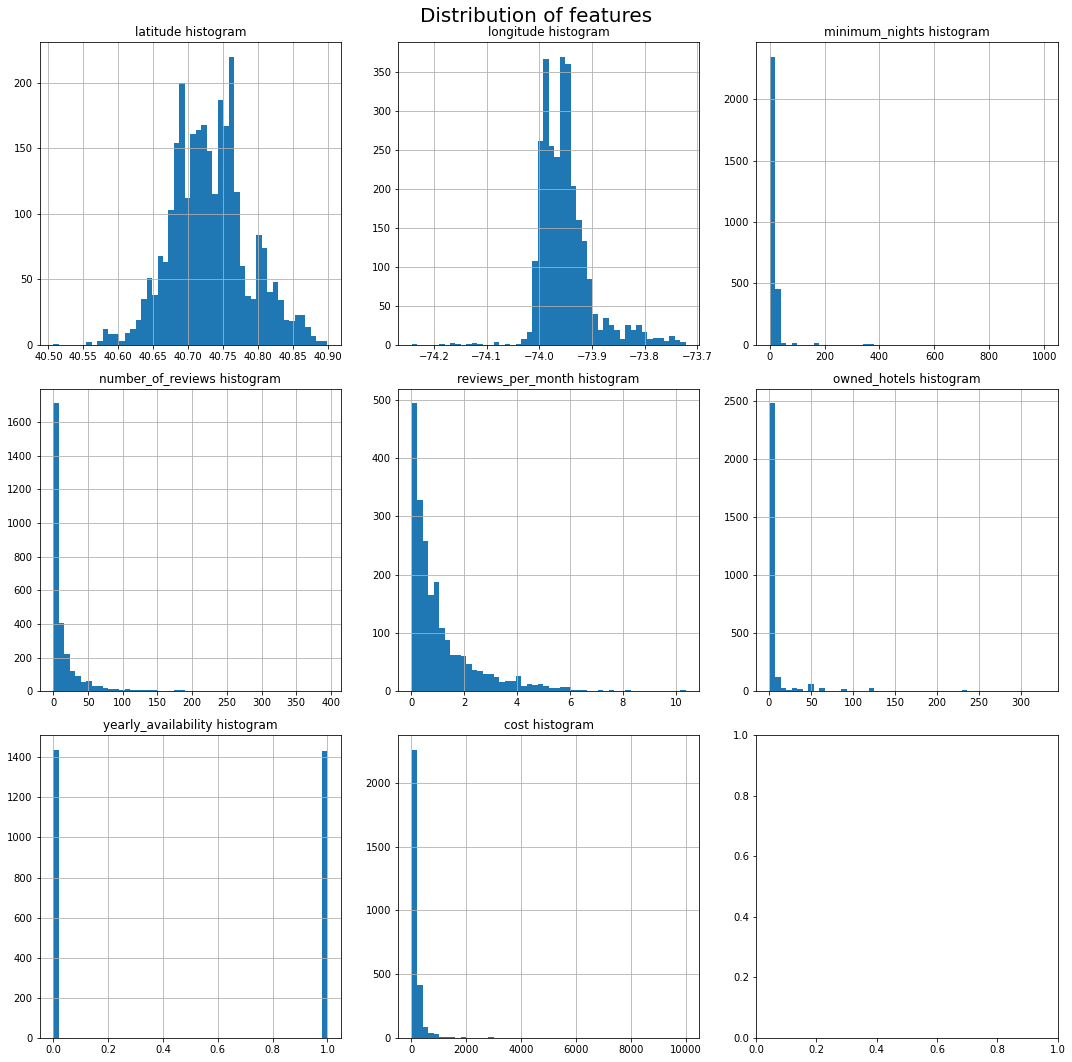

In [8]:
## Histograms of feature
def get_histogram(df,output):
    count=0
    for col in df.columns:
            count+=1
    if count%3==0:
        n_rows = count//3
    else:
        n_rows=(count//3)+1
    plt.subplots(n_rows,3,figsize=(15,15))
    i=0
    fig=[]
    for col in df.columns:
        if df[col].dtype != 'object':
            plt.subplot(n_rows,3,i+1)
            x=50
            df_new = df
            df_new[col].hist(bins=x)
            plt.title('{} histogram'.format(col))
            plt.suptitle('Distribution of features', fontsize=20)
            i+=1
        elif df[col].dtype == 'object':
#             col2=df[col].unique()
#             if(col=='month'):
#                 col2=sort_month(col2)
#             if(col=='day'):
#                 col2=sort_week(col2)
            plt.subplot(n_rows,3,i+1)
            df[col].value_counts().plot(kind='bar')
            plt.title('{} histogram'.format(col))
            i+=1
    plt.tight_layout()
    
display(get_histogram(df,'area'))

In [9]:
df.isna().sum()

latitude                 0
longitude                0
minimum_nights           0
number_of_reviews        0
reviews_per_month      676
owned_hotels             0
yearly_availability      0
cost                     0
dtype: int64

In [10]:
df['reviews_per_month']=df['reviews_per_month'].fillna(0)
df.isna().sum()

latitude               0
longitude              0
minimum_nights         0
number_of_reviews      0
reviews_per_month      0
owned_hotels           0
yearly_availability    0
cost                   0
dtype: int64

None

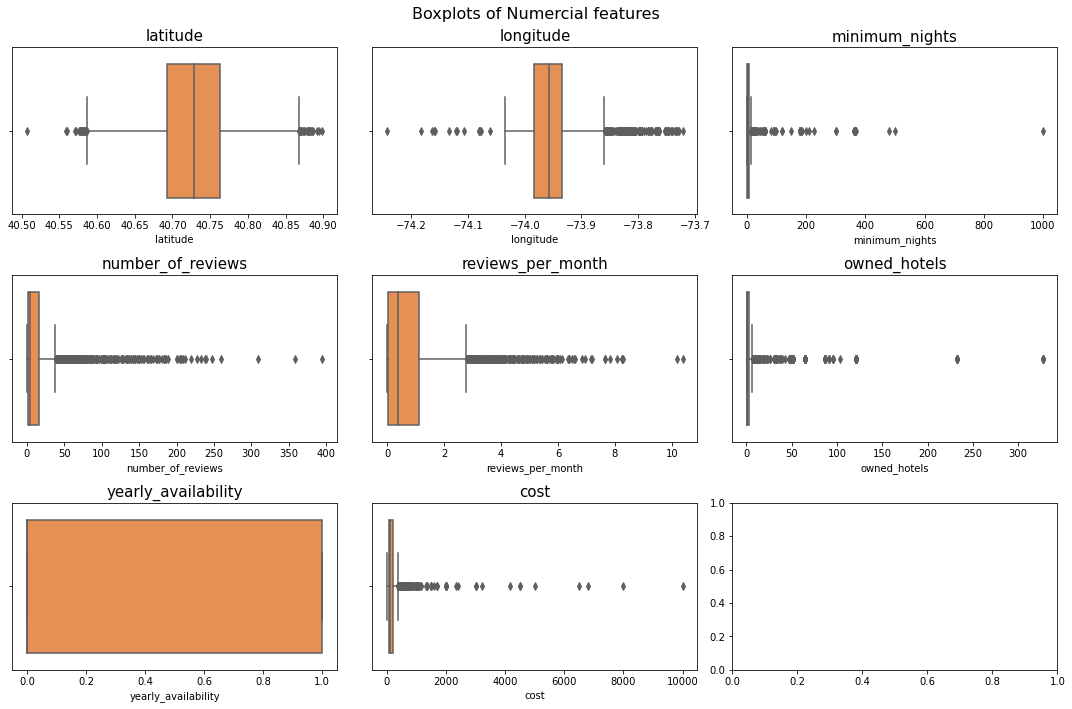

In [11]:
## Boxplots of numerical features
def boxplot_subplot(df):
    count=0
    for col in df.columns:
        if df[col].dtype!='object' and col!='Year':
            count+=1
        if count%3==0:
            n_rows = count//3
        else:
            n_rows=(count//3)+1
    plt.subplots(n_rows,3,figsize=(15,10))
    i=0
    fig=[]
    for col in df.columns:
        if df[col].dtype != 'object':
            fig.append(plt.subplot(n_rows,3,i+1))
            sns.boxplot(x=col,data=df,palette="Oranges_r",ax=fig[i]).set_title(col,fontsize=15)
            plt.suptitle('Boxplots of Numercial features', fontsize=16)
            plt.tight_layout()
            i+=1

display(boxplot_subplot(df))

<AxesSubplot:>

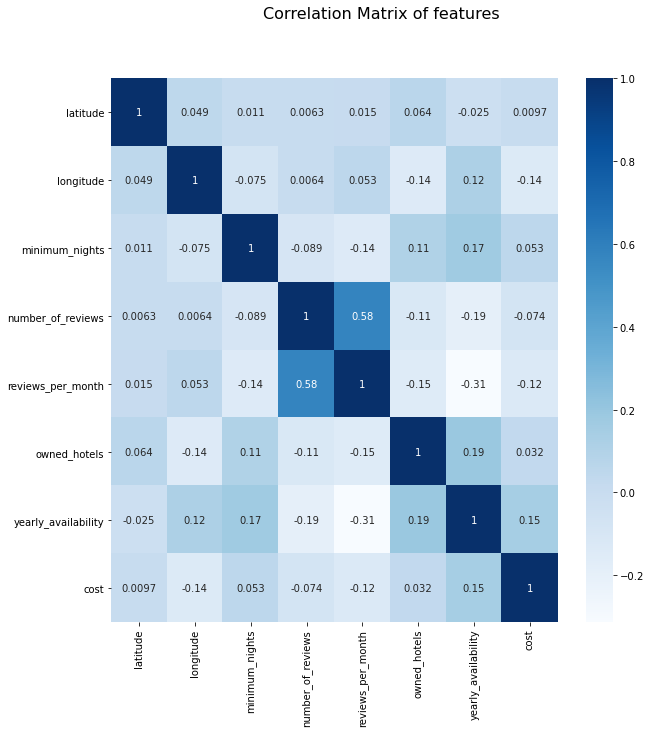

In [12]:
## Correlation matrix
plt.subplots(1,1,figsize=(10,10))
plt.subplot(1,1,1)
plt.suptitle('Correlation Matrix of features', fontsize=16)
corr = df.corr()
sns.heatmap(corr, cmap="Blues", annot=True)

In [13]:
def LabelEncode(df):
    df=df.copy()
    from sorted_months_weekdays import Month_Sorted_Month as sort_month, Weekday_Sorted_Week as sort_week
    for col in df.columns:
        col_dict = {}
        if df[col].dtype=='object':
            col2=df[col].unique()
            if col=='month':
                col2=sort_month(col2)
            elif col=='week':
                col2=sort_week(col2)
            z=1
            for i in col2:
                col_dict[i]=z
                z+=1
            df[col]=df[col].map(col_dict)
#             print(col)
    return df

In [14]:
df_encode=LabelEncode(df)
df_encode

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,owned_hotels,yearly_availability,cost
0,40.71854,-74.00439,5,7,0.56,1,0,170
1,40.64446,-73.95030,3,238,2.30,1,0,65
2,40.78573,-73.81062,1,0,0.00,1,1,85
3,40.73863,-73.98002,30,0,0.00,65,1,210
4,40.82426,-73.94630,3,38,0.42,3,1,75
...,...,...,...,...,...,...,...,...
2865,40.74316,-73.98038,2,0,0.00,1,1,400
2866,40.73523,-73.99465,3,2,0.07,1,1,180
2867,40.76619,-73.98987,3,17,0.67,1,0,179
2868,40.74637,-73.97207,30,0,0.00,49,1,200


In [15]:
df_input=df_encode.drop(columns=['cost'])
df_output=df_encode[['cost']]

In [16]:
scaler = StandardScaler()
scaler.fit(df_input)
df_scaled = pd.DataFrame(scaler.transform(df_input), columns=df_input.columns)
df_scaled

X_train, X_test, y_train, y_test = train_test_split(df_scaled, df_output, train_size=0.7, shuffle=True, random_state=1)

In [17]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

def adjusted_r2_score(r2, n, k):
    return 1-((1-r2)*(n-1)/(n-k-1))

def regression_fs():
    # create model
    model = Sequential()
    model.add(Dense(i+1, input_dim=i, kernel_initializer='normal', activation='relu'))
    model.add(Dense(i+1, activation='relu'))
    model.add(Dense(i+1, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

columns = X_train.columns.to_list()
fws_col=[]
temp_r2=-1000;

for i in range(1,len(columns)+1):
    FW_NN = regression_fs()
    FW_NN2 = FW_NN.fit(X_train.iloc[:,0:i], y_train, batch_size=10,validation_split = 0.2, verbose=0,epochs=100)
    
    predict_y = FW_NN.predict(X_test.iloc[:,0:i])
    r2_fws=r2_score(y_test,predict_y)
    if(r2_fws>temp_r2):
        fws_col.append(columns[i-1])
        temp_r2=r2_fws;

In [18]:
# Columns selected in Forward selection
fws_col

['latitude',
 'longitude',
 'number_of_reviews',
 'reviews_per_month',
 'owned_hotels',
 'yearly_availability']

In [19]:
X_train = X_train[fws_col]
X_test = X_test[fws_col]

Building Neural nets with linear activation function


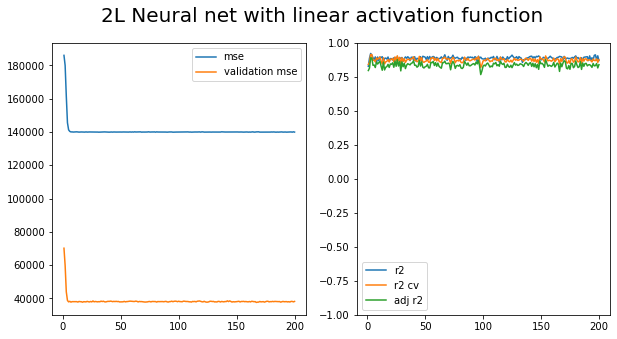

*******************************************************

Building Neural nets with relu activation function


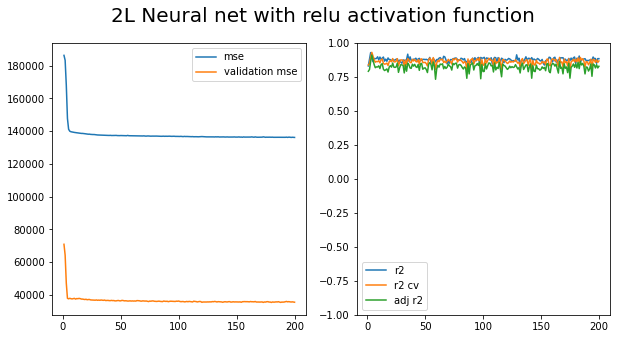

*******************************************************

Building Neural nets with sigmoid activation function


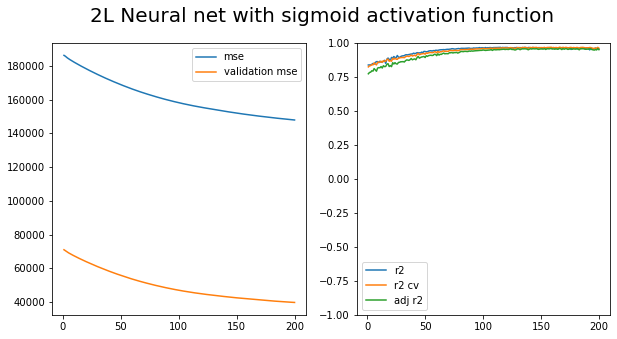

*******************************************************

Building Neural nets with tanh activation function


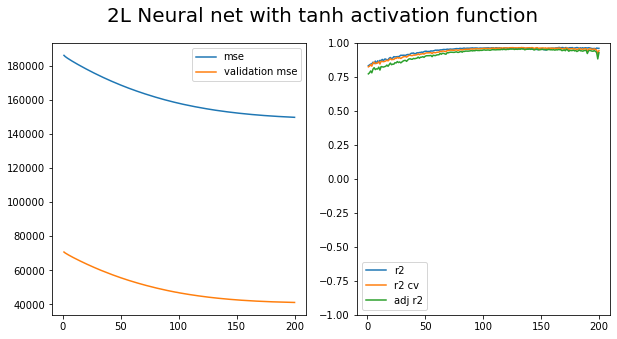

*******************************************************

Building Neural nets with elu activation function


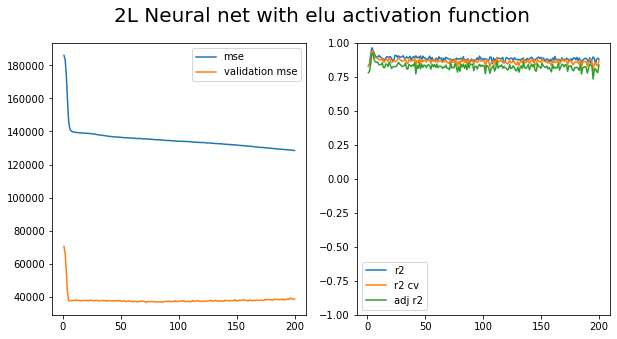

*******************************************************

Building Neural nets with softmax activation function


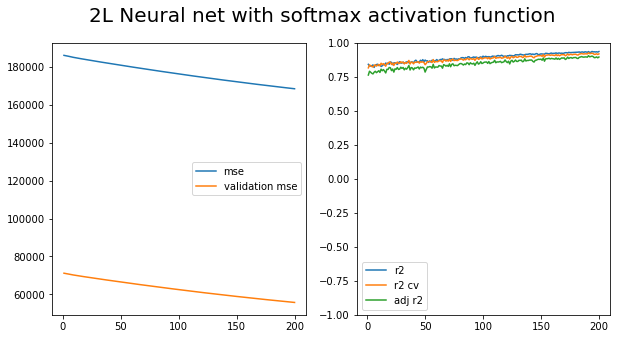

*******************************************************

Building Neural nets with softplus activation function


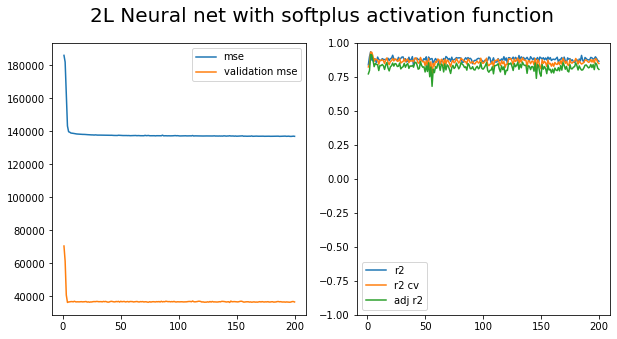

*******************************************************

Building Neural nets with softsign activation function


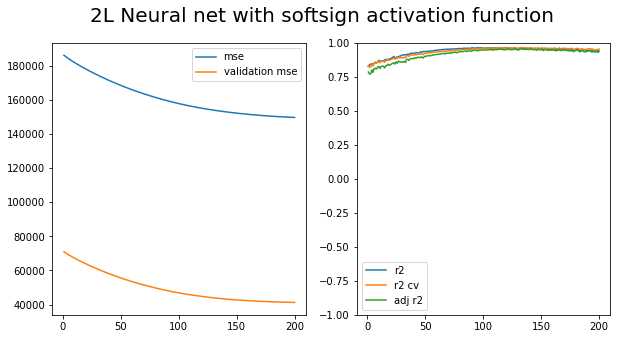

*******************************************************

Building Neural nets with selu activation function


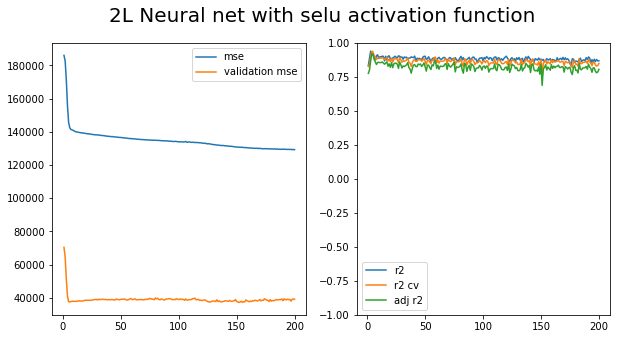

*******************************************************









In [21]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

def adjusted_r2_score(r2, n, k):
    return 1-((1-r2)*(n-1)/(n-k-1))

activation_list = ['linear','relu', 'sigmoid', 'tanh', 'elu','softmax','softplus','softsign','selu']
epoch_arr = [k for k in range(1,201)]

from keras import backend as K

def r2_coeff(y_true, y_pred):
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=-1)), axis=-1)
    return (1 - SS_res/(SS_tot + tf.keras.backend.epsilon()))
    

def adj_r2(y_true, y_pred):
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=-1)), axis=-1)
    return (1 - (1 - r2_coeff(y_true, y_pred)) * (tf.cast(tf.size(y_true), tf.float32) - 1) / (tf.cast(tf.size(y_true), tf.float32) - tf.cast(tf.rank(y_true), tf.float32) - 1))

def regression(i):
    # create model
    model = Sequential()
    model.add(Dense(len(fws_col)+1, input_dim=len(fws_col), kernel_initializer='normal', activation=i))
    model.add(Dense(len(fws_col)+1, activation=i))
    model.add(Dense(len(fws_col)+1, activation=i))
    model.add(Dense(1, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mse',r2_coeff, adj_r2])
    return model

r2_scores = []
adjusted_r2_scores = []
r2_scores_cv=[]
for i in activation_list:
    print("Building Neural nets with "+i+" activation function")
    Forest_fires_NN = regression(i)
    Forest_fires_NN_cv = regression(i)
    Forest_fires_NN2 = Forest_fires_NN.fit(X_train, y_train, batch_size=10,verbose=0,epochs=200)
    Forest_fires_NN_CV = Forest_fires_NN_cv.fit(X_train, y_train, batch_size=10,validation_split = 0.2, verbose=0,epochs=200)
    plt.subplots(1,2,figsize=(10,5))
    plt.suptitle("2L Neural net with "+i+" activation function", fontsize=20)
    plt.subplot(121)
    plt.plot( epoch_arr, Forest_fires_NN_CV.history['mse'],label="mse")
    plt.plot( epoch_arr,  Forest_fires_NN_CV.history['val_mse'],label="validation mse")
    plt.legend()
    plt.subplot(122)
    plt.plot( epoch_arr, Forest_fires_NN2.history['r2_coeff'],label="r2")
    plt.plot( epoch_arr, Forest_fires_NN_CV.history['r2_coeff'],label="r2 cv")
    plt.plot( epoch_arr, Forest_fires_NN_CV.history['adj_r2'],label="adj r2")
    plt.ylim([-1, 1])
    plt.legend()
    plt.show()
    
    predict_y = Forest_fires_NN.predict(X_test)
    predict_y_cv = Forest_fires_NN_cv.predict(X_test)
    r2=r2_score(y_test,predict_y)
    r2_scores.append(r2)
    adjusted_r2_scores.append(adjusted_r2_score(r2, X_train.shape[0],X_train.shape[1]-1))
    r2_scores_cv.append(r2_score(y_test,predict_y_cv))
#     Forest_fires_dict = Forest_fires_NN2.history
#     loss_values = Forest_fires_dict['loss']
#     val_loss_values = Forest_fires_dict['val_loss']
#     plt.figure()
#     plt.title('NN with '+i+' activation function')
#     plt.plot(loss_values, label="Training Loss")
#     plt.plot(val_loss_values, label="Validation Loss")
    
    print("*******************************************************\n")
print('\n')
print('\n')
print('\n')

In [22]:
print("************************* R2 scores of various activation functions *************************\n")
for i in range(len(activation_list)):
    print("R2 for NN using",activation_list[i],"activation is ",r2_scores[i]*100)
    print("Adj R2 for NN using",activation_list[i],"activation is ",adjusted_r2_scores[i]*100)
    print("R2 CV for NN using",activation_list[i],"activation is ",r2_scores_cv[i]*100)
    print('\n')
    

************************* R2 scores of various activation functions *************************

R2 for NN using linear activation is  4.138728065444219
Adj R2 for NN using linear activation is  3.8993142993739016
R2 CV for NN using linear activation is  4.286772304793585


R2 for NN using relu activation is  7.21973688159756
Adj R2 for NN using relu activation is  6.988017942740409
R2 CV for NN using relu activation is  7.105634656845783


R2 for NN using sigmoid activation is  0.9706550438488226
Adj R2 for NN using sigmoid activation is  0.7233290074947996
R2 CV for NN using sigmoid activation is  -0.3635682828027953


R2 for NN using tanh activation is  0.7192820040844317
Adj R2 for NN using tanh activation is  0.4713281629357913
R2 CV for NN using tanh activation is  -1.0370851169714257


R2 for NN using elu activation is  9.727076185380612
Adj R2 for NN using elu activation is  9.501619332696743
R2 CV for NN using elu activation is  10.444340629175775


R2 for NN using softmax activ

In [23]:
!jupyter nbconvert Project2_XL_NN(Expedia).ipynb --to=pdf --TemplateExporter.exclude_input=True

[NbConvertApp] Converting notebook Project2_XL_NN(Expedia).ipynb to pdf
[NbConvertApp] Writing 297152 bytes to Project2_XL_NN(Expedia).pdf
